# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from phik import phik_matrix
from utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set options for displaying dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

# 2. Load Dataset and Basic Information

In [3]:
pos_cash = load_data('dseb63_POS_CASH_balance.csv', 
                     filename_train='dseb63_application_train.csv', 
                     filename_test='dseb63_application_test.csv',
                     verbose=3)

Table: dseb63_POS_CASH_balance.csv
Shape: (8543375, 8)

Number of categorical variables: 1
Number of numerical variables: 7

Number of unique values of SK_ID_CURR: 289444
Number of unique values of SK_ID_PREV: 800337

Number of duplicate values: 0

Shape of train set: (246009, 123)
Number of overlapping SK_ID_CURR in dseb63_POS_CASH_balance.csv and dseb63_application_train.csv: 231531

Shape of test set: (61502, 122)
Number of overlapping SK_ID_CURR in dseb63_POS_CASH_balance.csv and dseb63_application_test.csv: 57913


,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR,TARGET
0,1803195,-31,48.00,45.00,Active,0,0,185279,0.00
1,1803195,-17,48.00,31.00,Active,0,0,185279,0.00
2,1803195,-21,48.00,35.00,Active,0,0,185279,0.00
3,1803195,-8,48.00,21.00,Active,0,0,185279,0.00
4,1803195,-4,48.00,17.00,Active,0,0,185279,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8543375 entries, 0 to 8543374
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   SK_ID_PREV             8543375 non-null  int64  
 1   MONTHS_BALANCE         8543375 non-null  int64  
 2   CNT_INSTALMENT         8521512 non-null  float64
 3   CNT_INSTALMENT_FUTURE  8521497 non-null  float64
 4   NAME_CONTRACT_STATUS   8543375 non-null  object 
 5   SK_DPD                 8543375 non-null  int64  
 6   SK_DPD_DEF             8543375 non-null  int64  
 7   SK_ID_CURR             8543375 non-null  int64  
 8   TARGET                 6833637 non-null  float64
dtypes: float64(3), int64(5), object(1)
memory usage: 586.6+ MB


### Observation:
- The DataFrame contains 8,543,375 entries and 9 columns, which suggests a substantial amount of data to work with.
- The dataset consists of integer (int64), floating-point (float64), and object (likely categorical or string) data types

# 3. Target column

In [4]:
pos_cash.TARGET.value_counts(dropna=False)

TARGET
0.00    6331185
NaN     1709738
1.00     502452
Name: count, dtype: int64

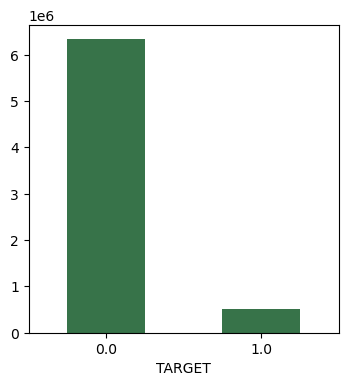

In [5]:
pos_cash.TARGET.value_counts().plot.bar(color='#377349', figsize=(4,4), rot=0);

### Observation:
- Most of the loans are paid back on time.
- The distribution of the target variable is right-skewed.
- Data is highly imbalanced that the proportion between class 0 and class 1 is about 92:8

# 4. Missing Values

In [6]:
df_missing = create_df_missing(pos_cash)
df_missing

,num_missing,pct_missing
TARGET,1709738,20.01
CNT_INSTALMENT_FUTURE,21878,0.26
CNT_INSTALMENT,21863,0.26
SK_ID_PREV,0,0.00
MONTHS_BALANCE,0,0.00
NAME_CONTRACT_STATUS,0,0.00
SK_DPD,0,0.00
SK_DPD_DEF,0,0.00
SK_ID_CURR,0,0.00


### Observation:
- The TARGET column is missing by 97.12% which are customers in application_train.csv.
- Besides TARGET, which refers to the prediction, out of the 8 other columns, 2 of them contain NaN values, and their percentage of missing values is less than 5%.

# 5. Define numeric and category features

In [7]:
pos_cash, cate_pos_cash, num_pos_cash = validate_dtype(pos_cash)

# 6. Imbalanced class

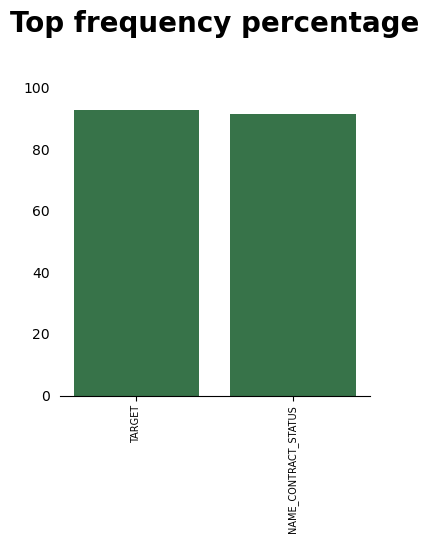

In [8]:
plot_imbalance(describe_class(cate_pos_cash), x_title=0.5, figsize=(4,4), title_size=20, show_grid=False)

### Observation:
- Both features are highly imbalanced, exceeding 80% of the data.

# 7. Outlier

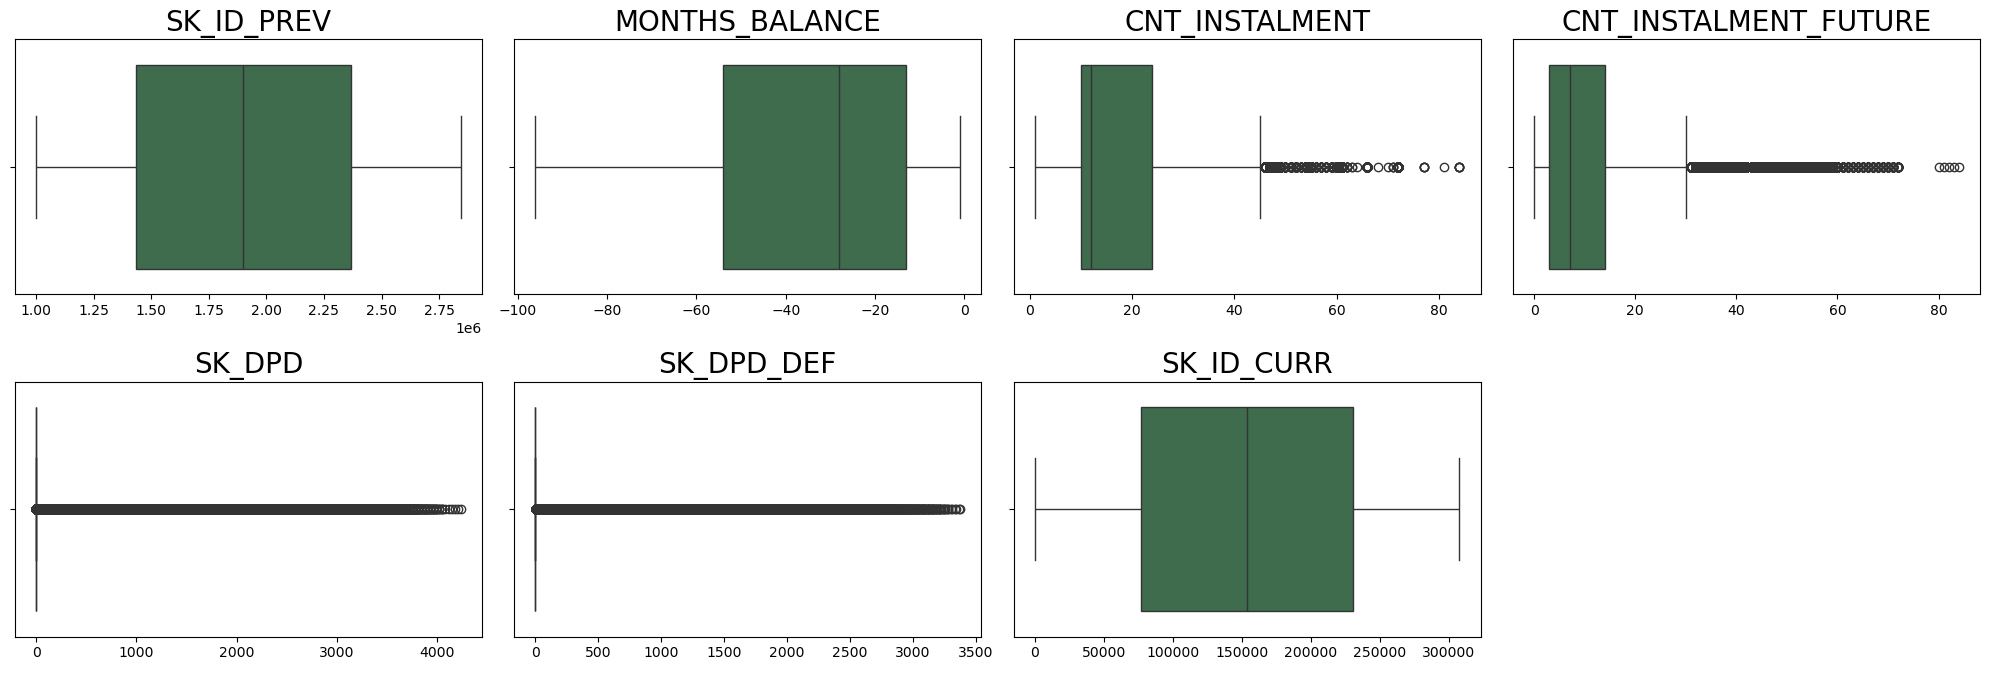

In [9]:
plot_boxplot(num_pos_cash, figsize=(20, 7))

### Observation:
- **Variable Distribution:** The variables SK_ID_PREV, MONTHS_BALANCE, CNT_INSTALMENT, and SK_ID_CURR display a compact distribution with no visible outliers. 
- **Potential Outliers:** The variables CNT_INSTALMENT_FUTURE, SK_DPD, and SK_DPD_DEF show a number of points beyond the whiskers of the boxplot, which are potential outliers. These might be cases of delinquent loans with past due days (SK_DPD) and days past due with tolerance considered (SK_DPD_DEF).
- In summary, while most loans appear to be current with few installments remaining, there are notable exceptions with significant delays in payments.

# 8. Anomalies

## 8.1. Numerical value

In [10]:
pos_cash.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,8543375.00,1903488.60,535938.73,1000001.00,1434475.00,1896878.00,2369096.00,2843499.00
MONTHS_BALANCE,8543375.00,-34.95,26.05,-96.00,-54.00,-28.00,-13.00,-1.00
CNT_INSTALMENT,8521512.00,17.03,12.00,1.00,10.00,12.00,24.00,84.00
CNT_INSTALMENT_FUTURE,8521497.00,10.47,11.14,0.00,3.00,7.00,14.00,84.00
SK_DPD,8543375.00,11.90,134.03,0.00,0.00,0.00,0.00,4231.00
SK_DPD_DEF,8543375.00,0.58,30.42,0.00,0.00,0.00,0.00,3373.00
SK_ID_CURR,8543375.00,153535.56,88716.61,0.00,76622.00,153315.00,230293.00,307510.00


### Observation:
- There appear to be no anomalies in the numerical values.

## 8.2. Categorical value

In [11]:
pos_cash['NAME_CONTRACT_STATUS'].value_counts()

NAME_CONTRACT_STATUS
Active                   7818577
Completed                 634872
Signed                     74625
Demand                      6110
Returned to the store       4591
Approved                    4221
Amortized debt               365
Canceled                      12
XNA                            2
Name: count, dtype: int64

### Observation:
- There appear to be no anomalies in the categorical values.

# 9. Correlation

In [12]:
cmat = CorrelationMatrix(pos_cash, drop_cols=['SK_ID_CURR', 'SK_ID_PREV'])

In [13]:
cmat.target_top()

,PhiK-Correlation
CNT_INSTALMENT,0.03
CNT_INSTALMENT_FUTURE,0.03
SK_DPD_DEF,0.03
SK_DPD,0.03
MONTHS_BALANCE,0.03
NAME_CONTRACT_STATUS,0.01


## Numerical value

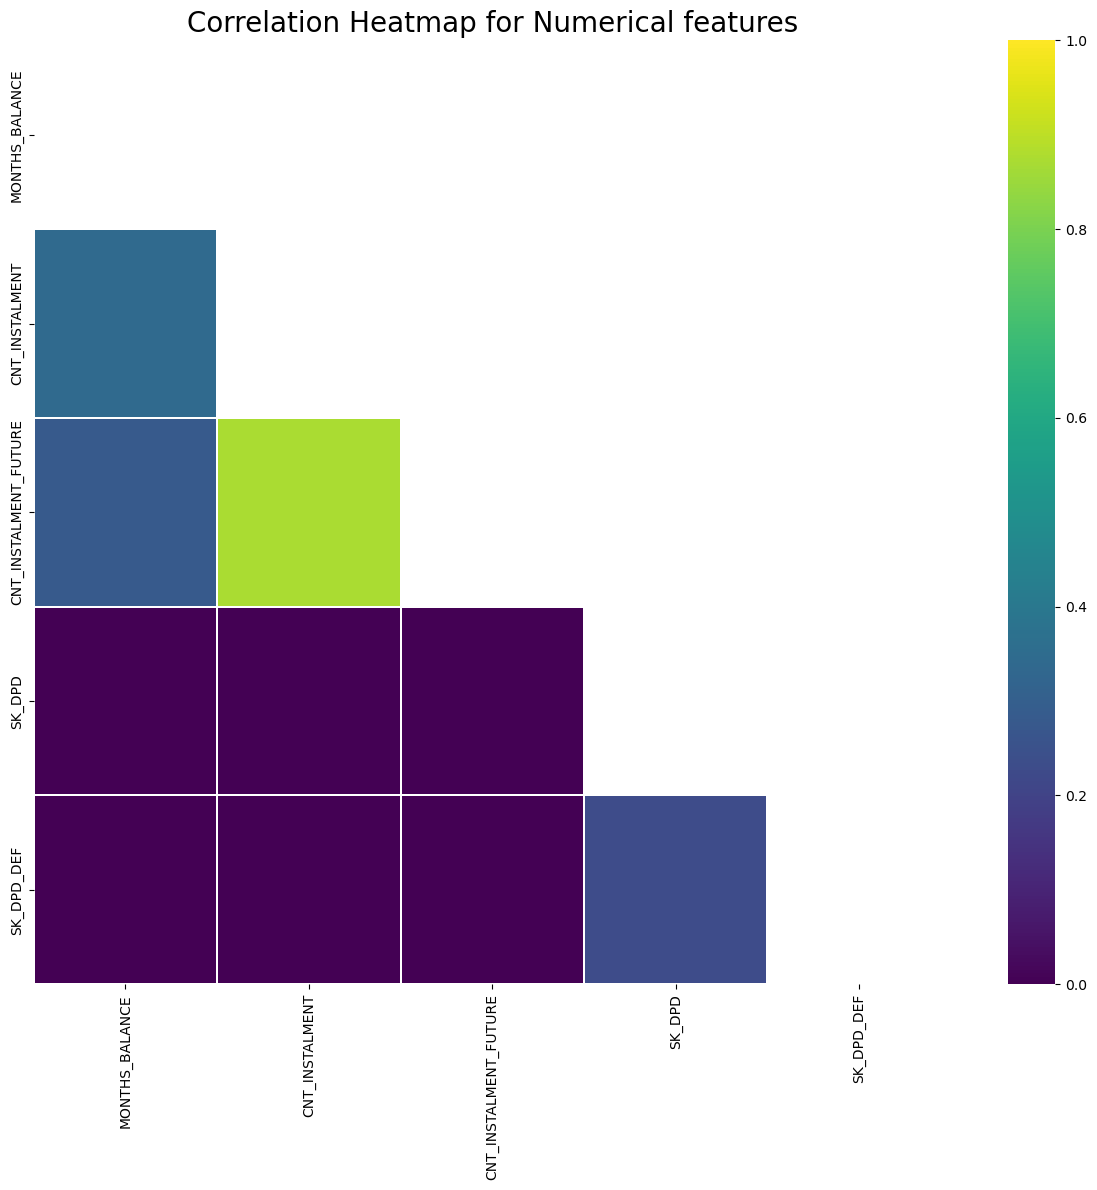

In [14]:
cmat.plot_correlation_matrix()

In [15]:
cmat.target_top_num()

,Correlation
CNT_INSTALMENT_FUTURE,0.02
MONTHS_BALANCE,0.02
CNT_INSTALMENT,0.02
SK_DPD,0.01
SK_DPD_DEF,0.01


### Observation:
- The heatmap indicates the strength and direction of the linear relationship between pairs of numerical features. From the heatmap, it's evident that some variables show moderate to high positive correlation with each other, while others have lower correlation values.

- The correlation table suggests that there is no linear relationship between these variables, or the relationship is so weak that it rounds down to 0 when limited to two decimal places.

# 10. Categorical Analysis

## 10.1 Count of Completed Loans

In [16]:
## get the most recent record of this dataset
pos_cash_filter = pos_cash.sort_values(by=['MONTHS_BALANCE']).groupby(["SK_ID_CURR", "SK_ID_PREV"]).last().reset_index()

In [17]:
pos_cash["NAME_CONTRACT_STATUS"].value_counts(normalize= True) * 100

NAME_CONTRACT_STATUS
Active                  91.52
Completed                7.43
Signed                   0.87
Demand                   0.07
Returned to the store    0.05
Approved                 0.05
Amortized debt           0.00
Canceled                 0.00
XNA                      0.00
Name: proportion, dtype: float64

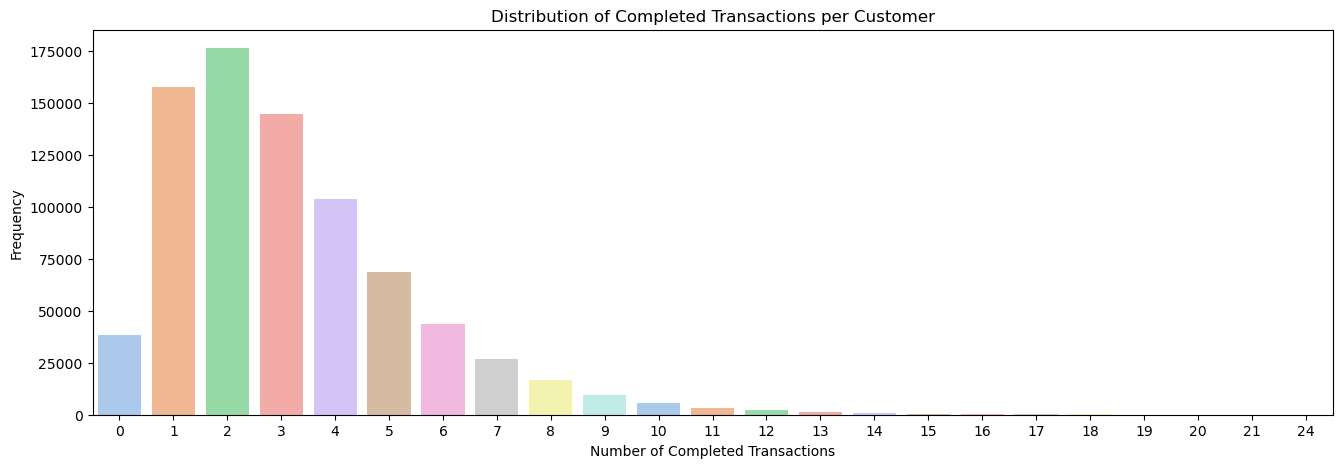

In [18]:
plot_completed_status(pos_cash_filter)

### Observation:
- **Right-Skewed Distribution**: The histogram indicates a right-skewed distribution. Most customers have a lower number of completed transactions, with the frequency decreasing as the number of transactions increases.
- **Mode**: The mode of the distribution, or the most common number of completed transactions per customer, appears to be between 1 and 2 transactions.
- **Long Tail**: There is a long tail extending to the right, suggesting that while the majority of customers have a small number of transactions, there are a few customers with many more transactions than average.
- **Low Frequency of High Transactions**: There are very few customers with a high number of completed transactions (above 10), as indicated by the bars being close to the x-axis.
- Most customers complete only a few transactions, which could suggest a variety of things depending on the context, such as a tendency to try out the service a few times before stopping or moving on, or it could be a sign of a one-off purchase pattern.

## 10.2 Overdue Status Counts

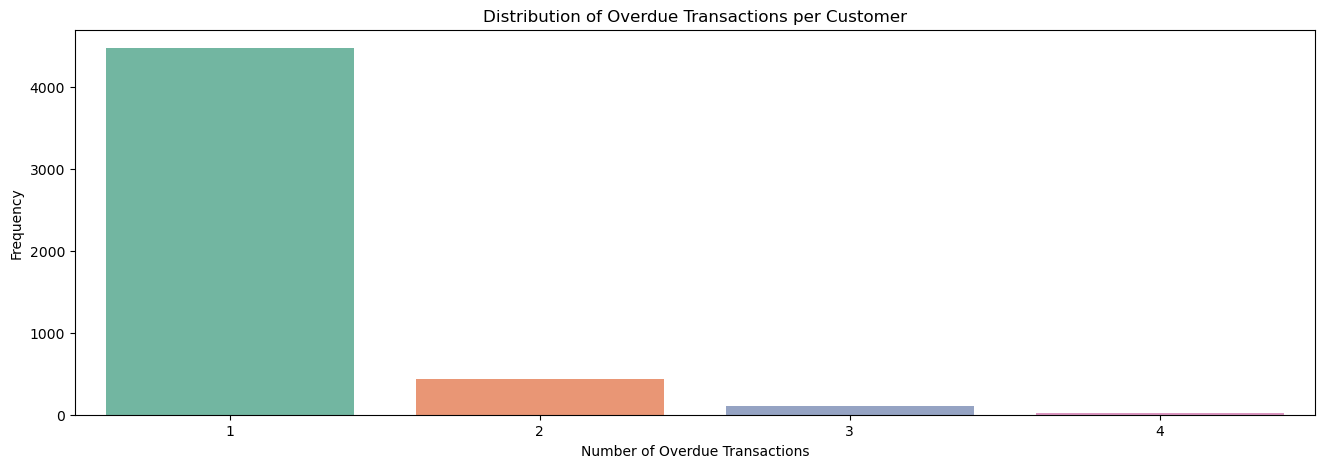

In [19]:
plot_overdue_status(pos_cash_filter)

### Observation:
- Overdue transactions are not widespread among customers, with most customers experiencing only one overdue transaction. This could indicate effective reminders or penalty systems that discourage repeated overdue behavior.
- The sharp decrease from one to two overdue transactions suggests that having one overdue transaction does not necessarily lead to a pattern of repeated overdue behavior among customers.
- The presence of any customers with three or four overdue transactions, although low in frequency, may still be a concern for the business and could signify specific issues that need addressing, such as financial difficulties or dissatisfaction with the service.

# 11. Numerical Analysis

## 11.1. MONTHS_BALANCE 

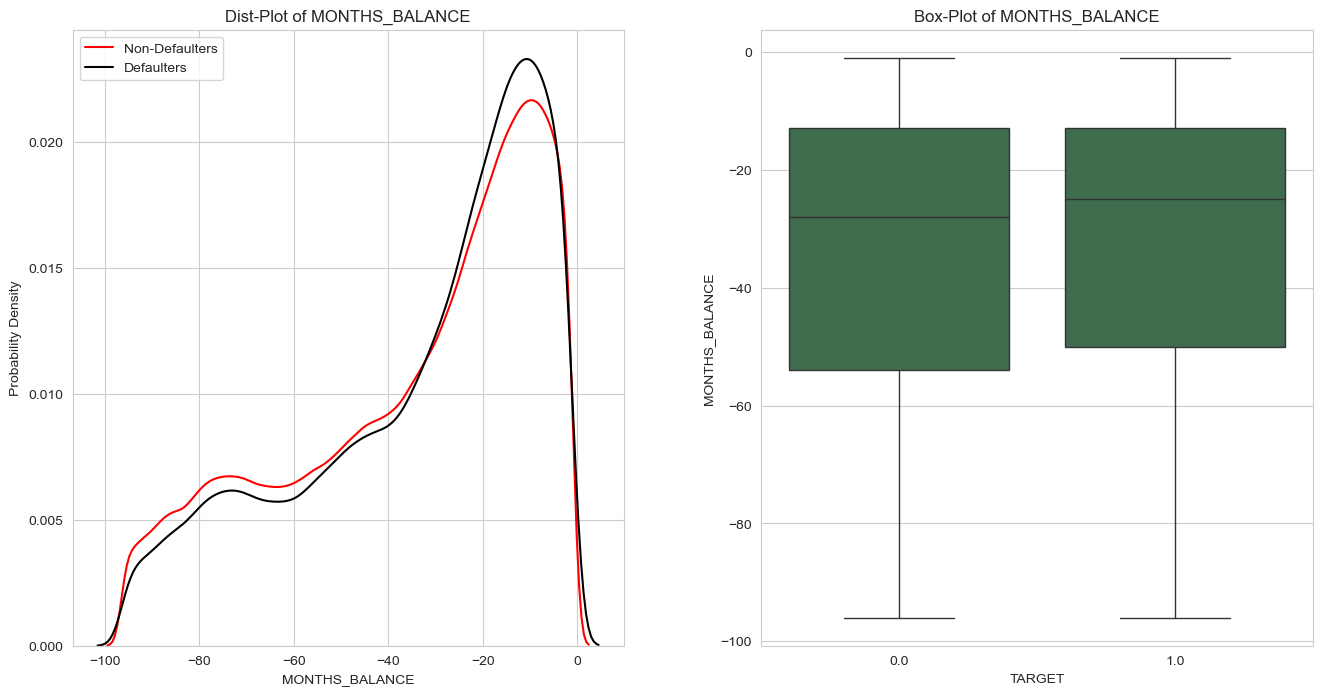

In [20]:
plot_continuous_variables(pos_cash, 'MONTHS_BALANCE', plots = ['distplot', 'box'], figsize = (16,8))

### Observation:
- The distribution of the MONTHS_BALANCE variable is skewed to the right, indicating that there are more observations with values closer to 0.
- There is a high frequency of observations between -20 and 0, which suggests that most of the balance information is relatively recent with respect to the loan application date.
- Therefore, the dataset likely contains a large number of recent loan applications since the balances are concentrated towards the application date.

## 11.2. CNT_INSTALMENT 

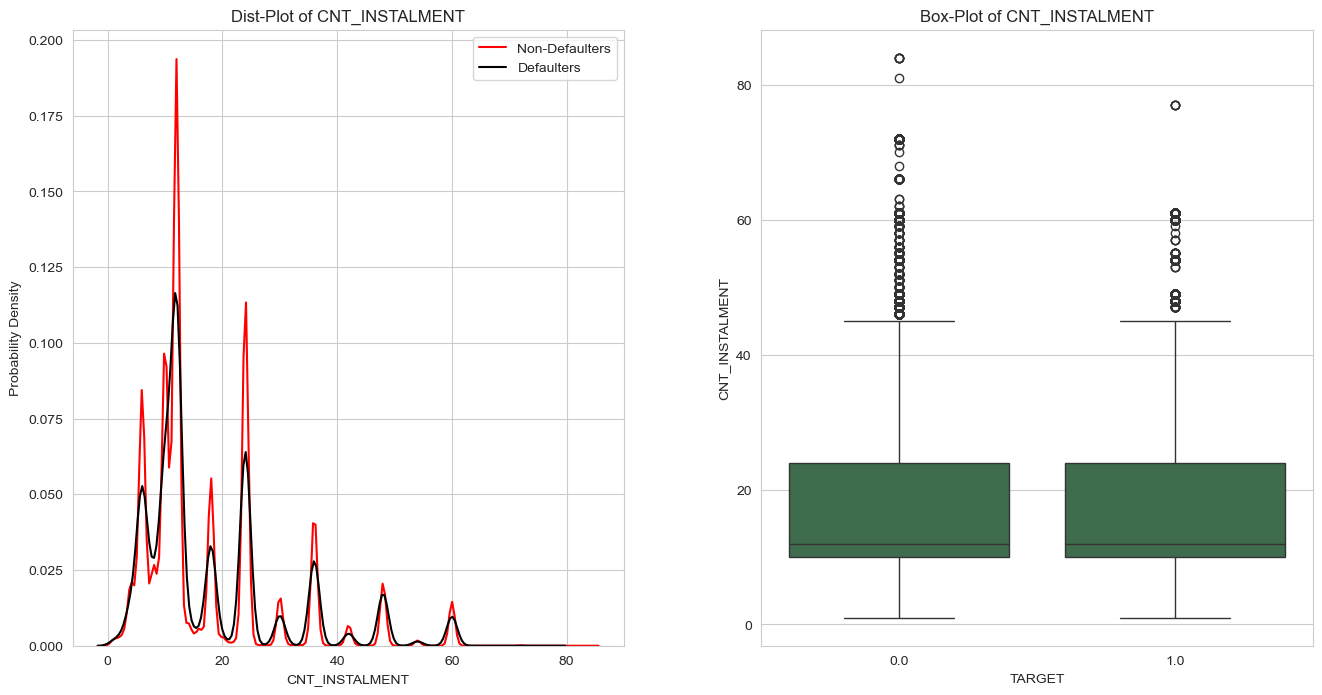

In [21]:
plot_continuous_variables(pos_cash, 'CNT_INSTALMENT', plots = ['distplot', 'box'], figsize = (16,8))

### Observation:
- The histogram shows a multimodal distribution with several peaks. This suggests that there are common installment terms that are more frequent than others. For example, certain numbers of installments (like 6, 12, 18, etc.) may be standard terms offered by the lender.
- The distribution has many spikes, which indicates that specific installment counts are very popular, likely due to standard loan term lengths.
- The outliers indicate that while there are common term lengths, there are also loans with much longer repayment periods.

## 11.3. CNT_INSTALMENT_FUTURE 

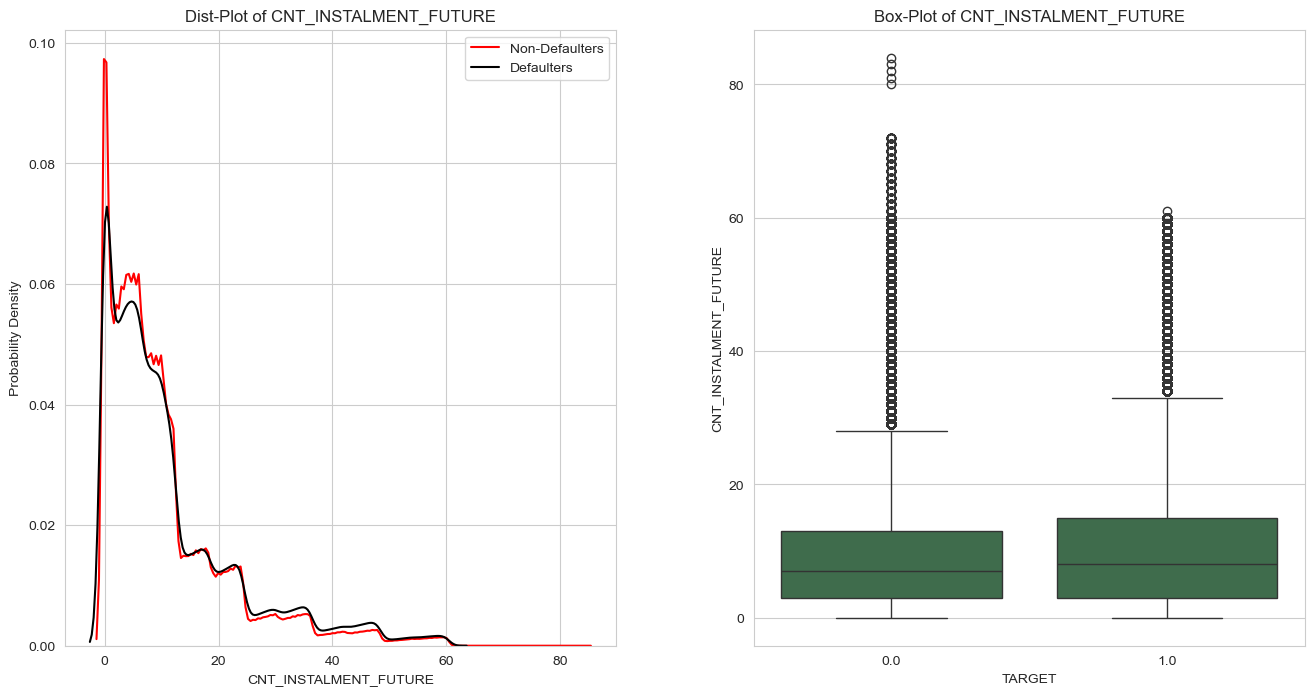

In [22]:
plot_continuous_variables(pos_cash, 'CNT_INSTALMENT_FUTURE', plots = ['distplot', 'box'], figsize = (16,8))

### Observation:
- The distribution is right-skewed, which indicates that most credits have a smaller number of future installments remaining.
- Most borrowers have a relatively small number of installments left to pay, which could imply that they are closer to paying off their credits.
- The presence of outliers with a high number of installments left might indicate some long-term loans or cases where the borrower has extended the credit period.

## 11.4. DPD & DPD_DEF 

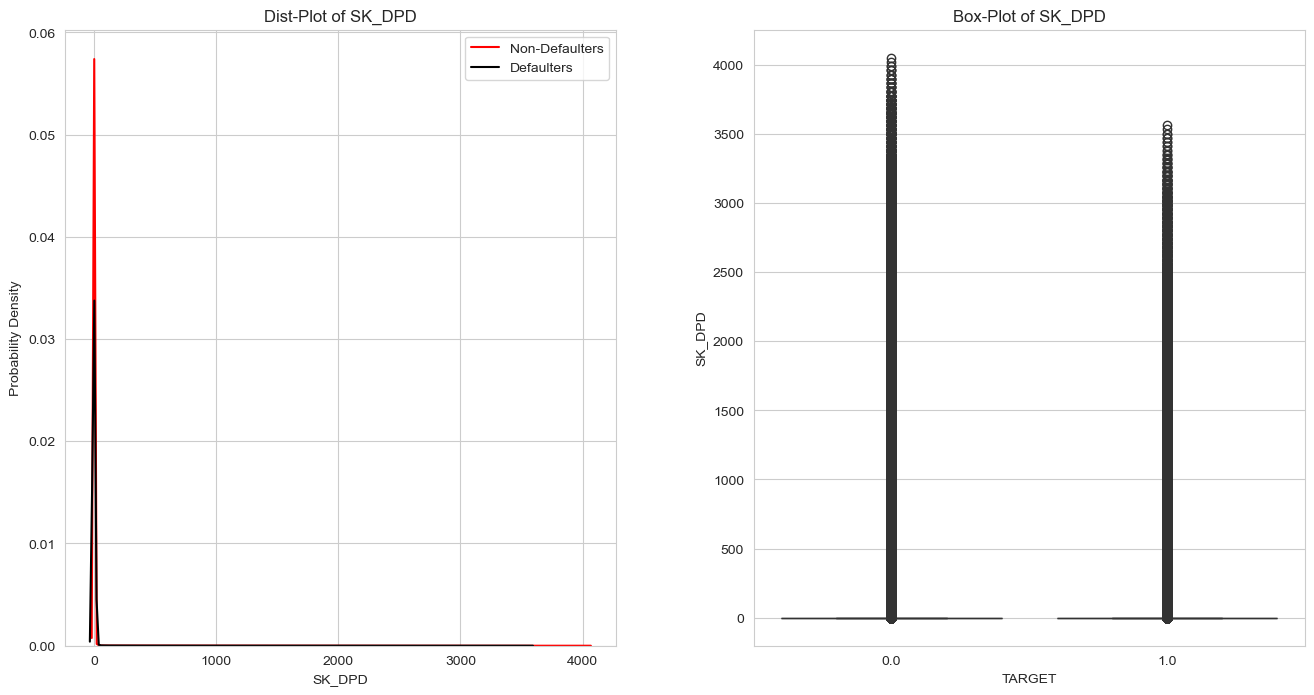

In [23]:
plot_continuous_variables(pos_cash, 'SK_DPD', plots = ['distplot', 'box'], figsize = (16,8))

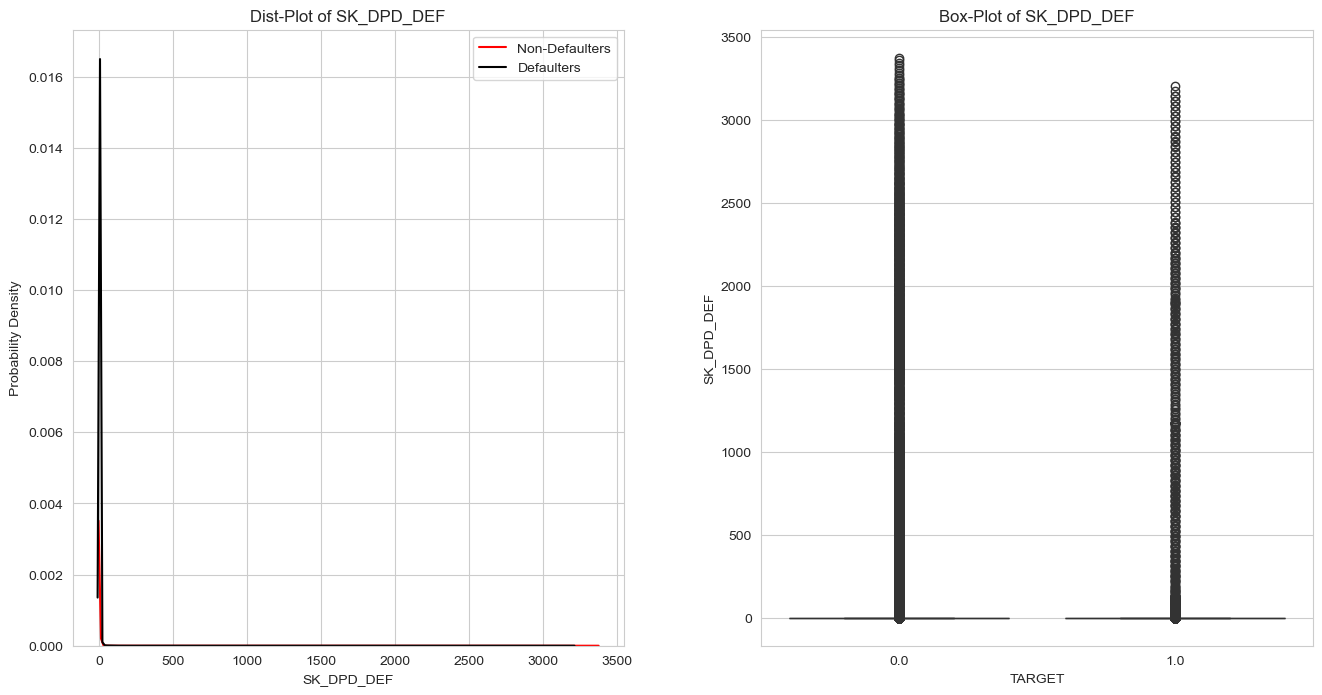

In [24]:
plot_continuous_variables(pos_cash, 'SK_DPD_DEF', plots = ['distplot', 'box'], figsize = (16,8))

### Observation:
- Most of the loan payments in the dataset are being made on time or have only minor delinquencies.
- There is a small proportion of loans with severe payment issues, as evidenced by the long tails in the boxplots.
- The measures SK_DPD and SK_DPD_DEF may be useful in identifying loans with significant payment issues, which could be a risk indicator for lenders.
- The similarity in the shapes of both distributions suggests that the overall patterns of payment behavior are similar, whether or not a tolerance is applied.